<a href="https://colab.research.google.com/github/the-SQuAD-squad/IR/blob/electra/IR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install wikipedia-api

In [ ]:
import wikipediaapi
wiki_wiki = wikipediaapi.Wikipedia('en')
cat = wiki_wiki.page("Category:Physics")
print("Category members: Category:Physics")
for p in cat.categorymembers.values():
  if p.namespace == wikipediaapi.Namespace.CATEGORY:
    # it is category, so you have to make decision
    # if you want to fetch also text from pages that belong
    # to this category
    print(p)
  elif p.namespace == wikipediaapi.Namespace.MAIN:
    # it is page => we can get text
    print(p)
    print(p.text)

In [ ]:
def print_categorymembers(categorymembers, level=0, max_level=3):
        for c in categorymembers.values():
            print("%s: %s (ns: %d)" % ("*" * (level + 1), c.title, c.ns))
            if c.ns == wikipediaapi.Namespace.CATEGORY and level < max_level:
                print_categorymembers(c.categorymembers, level=level + 1, max_level=max_level)

cat = wiki_wiki.page("Category:Artificial intelligence")
print_categorymembers(cat.categorymembers)

In [ ]:
wiki_wiki = wikipediaapi.Wikipedia('en')

page_py = wiki_wiki.page('Python_(programming_language)')
print(page_py.text)

In [1]:
#@title Init { form-width: "25%" }
import os
import random
import math
import numpy as np
import tensorflow as tf
import json
import pandas as pd
import re
import string
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

!pip install tokenizers
from tokenizers import BertWordPieceTokenizer

pd.set_option('display.max_colwidth', -1)

# fix random seeds
seed_value = 42 #@param {type:"integer"}

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# BERT params
max_seq_length = 512
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)


     |████████████████████████████████| 3.2MB 8.9MB/s 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
#@title df creation { form-width: "25%" }

# the official dataset is identical to the provided one
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json -O training_set.json

with open("training_set.json", "r") as f:
    json_file = json.load(f)
data = json_file["data"]

rows = []
for document in data:
  for par in document['paragraphs']:
    for qas in par['qas']:
      rows.append({
        'id' : qas['id'],
        'title': document["title"],
        'passage': par['context'],
        'question' : qas['question'],
        'answer_idx' : (qas['answers'][0]['answer_start'], 
                    qas['answers'][0]['answer_start'] + len(qas['answers'][0]['text'])),
        'answer_text' : qas['answers'][0]['text']
      })

df_original = pd.DataFrame(rows)

--2021-02-18 18:22:30--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.110.153, 185.199.108.153, 185.199.109.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [application/json]
Saving to: ‘training_set.json’

training_set.json   100%[===================>]  28.88M  89.7MB/s    in 0.3s    

2021-02-18 18:22:32 (89.7 MB/s) - ‘training_set.json’ saved [30288272/30288272]



In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(y_np.flatten(), viterbi_sequence.numpy().flatten(), 
                        sample_weight=tf.reshape(sample_weights,[-1]),
                        average='macro', zero_division=0, 
                        labels=[*p2i.values()])

from sklearn.neighbors import NearestNeighbors

embeddings = get_embeddings(words)
tree = NearestNeighbors(
    n_neighbors=30, algorithm='ball_tree',
    metric='cosine')
tree.fit(X)

In [ ]:
#@title preprocessing { form-width: "25%" }

import nltk
import re 
import math
import random as rand

nltk.download('punkt')
from nltk.stem.porter import PorterStemmer # for stemming

from tqdm.notebook import tqdm


def preprocess_text(text):
    """
    Given an iterable containing sentences, pre-process each sentence.

    :param: 
        - text: list of text to be pre-processed (Iterable)
    :return:
        - text: pre-processed text (List)
    """

    REPLACE_WITH_SPACE = re.compile(r"\n") 
    text = [REPLACE_WITH_SPACE.sub(" ", line) for line in text]

    # we don't remove symbols, but just put a space before and after them. We did this because we noticed that Glove contains an embedding also for
    # them, so, in this way, we are able to split these symbols from the text when computing sentence tokens
    text = [re.sub(r"([(.;:!\'ˈ~?,\"(\[\])\\\/\-–\t```<>_#$€@%*+—°′″“”×’^₤₹‘])", r'', line) for line in text]

    # we noticed that in the text sometimes we find numbers and the following word merged together (ex: 1980february),
    # so we put a space between the number and the word
    text = [re.sub(r"(\d+)([a-z]+)", r'\1 \2', line) for line in text] 
    text = [re.sub('\s{2,}', ' ', line.strip()) for line in text]   # replacing more than one consecutive blank spaces with only one of them

    return text

    stemmed_lines = []
    for line in tqdm(text):
        tokens = nltk.word_tokenize(line)
        stems = []
        for item in tokens:
            stems.append(PorterStemmer().stem(item))
        stemmed_lines.append(' '.join(stems))

    return stemmed_lines

# Creating a copy of the original dataframe (we do this because we want to be able to compare the results of our processing with the original data)
df = df_original.copy()

# pre-process passage and question text
df['passage'] = preprocess_text(df_original['passage'])
df['question'] = preprocess_text(df_original['question'])
df['answer_text'] = preprocess_text(df_original['answer_text'])




# Comparing Original and Pre-Processed
for i in range(3):
    a = rand.randint(0,1000)
    print('ORIGINAL AND PREPROCESSED PASSAGE:')
    print(df_original.iloc[a]['passage'])
    print(df.iloc[a]['passage'])
    
    print()
    print('ORIGINAL AND PREPROCESSED QUESTION:')
    print(df_original.iloc[a]['question'])
    print(df.iloc[a]['question'])
    print()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
ORIGINAL AND PREPROCESSED PASSAGE:
Notre Dame's conference affiliations for all of its sports except football and fencing changed in July 2013 as a result of major conference realignment, and its fencing affiliation will change in July 2014. The Irish left the Big East for the ACC during a prolonged period of instability in the Big East; while they maintain their football independence, they have committed to play five games per season against ACC opponents. In ice hockey, the Irish were forced to find a new conference home after the Big Ten Conference's decision to add the sport in 2013–14 led to a cascade of conference moves that culminated in the dissolution of the school's former hockey home, the Central Collegiate Hockey Association, after the 2012–13 season. Notre Dame moved its hockey team to Hockey East. After Notre Dame joined the ACC, the conference announced it would

In [ ]:
df["passage"]=df["passage"].str.lower()
df["question"]=df["question"].str.lower()
df["answer_text"]=df["answer_text"].str.lower()

In [ ]:
#@title clean dataset { form-width: "25%" }

!gcloud config set project feisty-mechanic-221914
!gsutil cp gs://squad_squad/error_IDs.txt ./error_IDs.txt

with open("error_IDs.txt", "r") as f:
    unwanted_id = f.read()

unwanted_id = unwanted_id.split("\n")[:-1]
df_clean = df.set_index('id')
df_clean = df_clean.drop(unwanted_id)

df_original_clean = df_original.set_index('id')
df_original_clean = df_original_clean.drop(unwanted_id)

Updated property [core/project].
Copying gs://squad_squad/error_IDs.txt...
/ [1 files][  5.7 KiB/  5.7 KiB]                                                
Operation completed over 1 objects/5.7 KiB.                                      


In [ ]:
#@title split { form-width: "25%" }

split_value = 0.1 #@param {type:"number"} 
val_dim = int(len(df_clean['title'].unique()) * split_value)
test_titles = np.random.choice(df_clean['title'].unique(), size=val_dim, replace=False)

# creating train and val sets
df_test = df_clean[df_clean['title'].isin(test_titles)]
df_train = df_clean[~(df_clean['title'].isin(test_titles))]

df_original_test = df_original_clean[df_original_clean['title'].isin(test_titles)]
df_original_train = df_original_clean[~(df_original_clean['title'].isin(test_titles))]


In [ ]:
from sklearn.feature_extraction.text import  TfidfVectorizer

passage_prep_train = df_train['passage'].unique().tolist()
passage_train = df_original_train['passage'].unique().tolist()

vectorizer =  TfidfVectorizer()
# tokenization and creation of Bag of Words representation
passage_tf_idf = vectorizer.fit_transform(passage_dict_prep_train)


In [ ]:
passage_prep_test = df_test['passage'].unique().tolist()
passage_test = df_original_test['passage'].unique()

In [ ]:
passage_test_tf_idf = vectorizer.transform(passage_prep_test)

In [ ]:
question_tf_idf = vectorizer.transform(df_test['question'].tolist())

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
results = cosine_similarity(passage_test_tf_idf,question_tf_idf)

In [ ]:
i = 0

for j,result in enumerate(results.T):
    if passage_test[np.argmax(result)]==df_original_test['passage'].tolist()[j]:
        i+=1
print(f"{i/len(df_original_test):.2%}")


58.60%


In [ ]:
i = 0
accuracy = []
for k in tqdm(range(1,50)):
    for j,result in enumerate(results.T):
        result = np.argsort(result)
        if df_original_test['passage'].tolist()[j] in [text for text in passage_test[result[-k:].tolist()]]:
            i+=1
    accuracy.append(i/len(df_original_test))
    i = 0



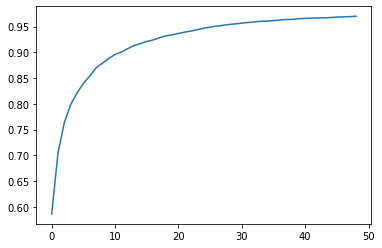

In [ ]:
from matplotlib import pyplot as plt

plt.plot(accuracy)

# BERT IR

In [3]:
#@title Init { form-width: "25%" }
import os
import random
import math
import numpy as np
import tensorflow as tf
import json
import pandas as pd
import re
import string
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

!pip install tokenizers
from tokenizers import BertWordPieceTokenizer

!pip install transformers
import transformers
from transformers import AutoTokenizer
pd.set_option('display.max_colwidth', -1)

# fix random seeds
seed_value = 42 #@param {type:"integer"}

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# BERT params
max_seq_length = 512
# Huggingface bert and associated tokenizer
pretrained_model_str = "google/electra-small-discriminator"
bert_hf_layer = transformers.TFElectraModel.from_pretrained(
    pretrained_model_str, output_attentions=True)

#pretrained_model_str = "roberta-base"
#bert_hf_layer = transformers.TFRobertaModel.from_pretrained(
    #pretrained_model_str, output_attentions=True)

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_str)

     |████████████████████████████████| 1.8MB 8.5MB/s 
     |████████████████████████████████| 890kB 49.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=e4c3b15c870d3af01f4933b35d205f8d2bd59f1969a165f4755899669e4813cf
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at google/electra-small-discriminator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.


In [4]:
#@title df creation { form-width: "25%" }

# the official dataset is identical to the provided one
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json -O training_set.json

with open("training_set.json", "r") as f:
    json_file = json.load(f)
data = json_file["data"]

rows = []
for document in data:
  for par in document['paragraphs']:
    for qas in par['qas']:
      rows.append({
        'id' : qas['id'],
        'title': document["title"],
        'passage': par['context'],
        'question' : qas['question'],
        'answer_idx' : (qas['answers'][0]['answer_start'], 
                    qas['answers'][0]['answer_start'] + len(qas['answers'][0]['text'])),
        'answer_text' : qas['answers'][0]['text']
      })

df_original = pd.DataFrame(rows)

--2021-02-18 18:23:03--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.110.153, 185.199.108.153, 185.199.109.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [application/json]
Saving to: ‘training_set.json’

training_set.json   100%[===================>]  28.88M  60.2MB/s    in 0.5s    

2021-02-18 18:23:03 (60.2 MB/s) - ‘training_set.json’ saved [30288272/30288272]



In [5]:
#@title clean dataset { form-width: "25%" }

!gcloud config set project feisty-mechanic-221914
!gsutil cp gs://squad_squad/error_IDs.txt ./error_IDs.txt

with open("error_IDs.txt", "r") as f:
    unwanted_id = f.read()

unwanted_id = unwanted_id.split("\n")[:-1]
df_bert = df_original.set_index('id')
df_bert = df_bert.drop(unwanted_id)
df_bert.head()

Updated property [core/project].
Copying gs://squad_squad/error_IDs.txt...
/ [1 files][  5.7 KiB/  5.7 KiB]                                                
Operation completed over 1 objects/5.7 KiB.                                      


,title,passage,question,answer_idx,answer_text
id,,,,,
5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?,"(515, 541)",Saint Bernadette Soubirous
5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",What is in front of the Notre Dame Main Building?,"(188, 213)",a copper statue of Christ
5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",The Basilica of the Sacred heart at Notre Dame is beside to which structure?,"(279, 296)",the Main Building
5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",What is the Grotto at Notre Dame?,"(381, 420)",a Marian place of prayer and reflection
5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary rep

In [48]:
#@title BERT preprocessing { form-width: "25%" }
from tqdm import tqdm

def preprocess_bert(text):
    tokenized_text = tokenizer(list(text), padding="max_length", max_length=max_seq_length, truncation=True)
    return tokenized_text.input_ids

df_bert_preprocessed = df_bert.copy()
# pre-process passage and question text
print("Preprocessing passage...")
df_bert_preprocessed['passage'] = preprocess_bert(df_bert['passage'])
print("Preprocessing question...")
df_bert_preprocessed['question'] = preprocess_bert(df_bert['question'])
df_bert_preprocessed.head()

Preprocessing passage...
Preprocessing question...


,title,passage,question,answer_idx,answer_text
id,,,,,
5733be284776f41900661182,University_of_Notre_Dame,"[101, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, ...]","[101, 2000, 3183, 2106, 1996, 6261, 2984, 9382, 3711, 1999, 8517, 1999, 10223, 26371, 2605, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","(515, 541)",Saint Bernadette Soubirous
5733be284776f4190066117f,University_of_Notre_Dame,"[101, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, ...]","[101, 2054, 2003, 1999, 2392, 1997, 1996, 10289, 8214, 2364, 2311, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","(188, 213)",a copper statue of Christ
5733be284776f41900661180,University_of_Notre_Dame,"[101, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, ...]","[101, 1996, 13546, 1997, 1996, 6730, 2540, 2012, 10289, 8214, 2003, 3875, 2000, 2029, 3252, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","(279, 296)",the Main Building
5733be284776f41900661181,University_of_Notre_Dame,"[101, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, ...]","[101, 2054, 2003, 1996, 24665, 23052, 2012, 10289, 8214, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [58]:

# negative mining loss oriented data loader

class IRDataset(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size):
        self.df = df
        self.batch_size = batch_size

    def __len__(self):
        return 2 * math.ceil(len(self.df)/self.batch_size)

    def __getitem__(self, idx):
        half = self.batch_size//2
        q = self.df['question'].iloc[idx * half : (idx + 1) * half].tolist()
        p = self.df['passage'].iloc[idx * half : (idx + 1) * half].tolist()
        rnd = np.random.randint(0,len(self.df), half)                                #####################################################################################################
        notp = self.df['passage'].iloc[rnd].tolist()
        y = half*[1]+half*[0]
        return (np.stack(p+notp), np.stack(q+q)), np.array(y)


split_value = 0.1 
val_dim = int(len(df_bert_preprocessed['title'].unique()) * split_value)
val_titles = np.random.choice(df_bert_preprocessed['title'].unique(), size=val_dim, replace=False)

df_bert_val = df_bert_preprocessed[df_bert_preprocessed['title'].isin(val_titles)]
df_bert_train = df_bert_preprocessed[~(df_bert_preprocessed['title'].isin(val_titles))]

In [65]:
#@title model definition { form-width: "25%" }
import tensorflow as tf
from tensorflow.keras.losses import cosine_similarity, MSE

input_passage_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_passage_ids')
input_question_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_question_ids')

passage_encoding = bert_hf_layer(input_ids=input_passage_ids).last_hidden_state[:,0]
question_encoding = bert_hf_layer(input_ids=input_question_ids).last_hidden_state[:,0]

output = tf.stack([passage_encoding, question_encoding],axis=-1)

model = keras.Model(inputs=[input_passage_ids, input_question_ids], 
                    outputs=output,
                    name="BERT_IR")

def similarity_loss(y_true, y_pred):
    cs = -(cosine_similarity(y_pred[:,:,0], y_pred[:,:,1]) +1) /2
    return MSE(y_true, cs)

optimizer = keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.summary(line_length=150)

Model: "BERT_IR"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_passage_ids (InputLayer)                   [(None, 512)]                    0                                                                   
______________________________________________________________________________________________________________________________________________________
input_question_ids (InputLayer)                  [(None, 512)]                    0                                                                   
______________________________________________________________________________________________________________________________________________________
tf_electra_model (TFElectraModel)                TFBaseModelOutput(last_hidde

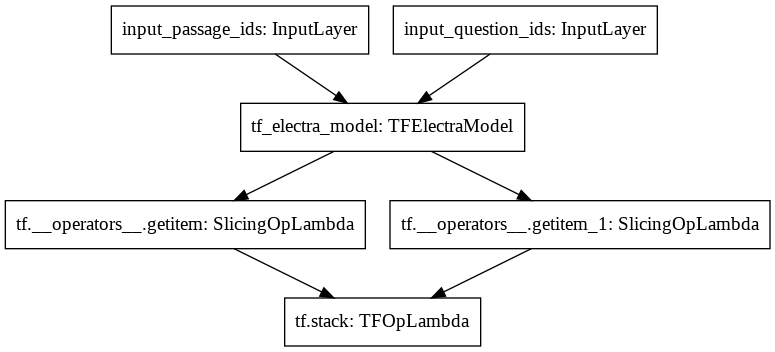

In [25]:
tf.keras.utils.plot_model(model)

In [66]:
#@title train { form-width: "25%" }
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
batch_size = 8
seq_train = IRDataset(df_bert_train, batch_size)
seq_val = IRDataset(df_bert_val, batch_size)
epochs = 200
steps_per_epoch = 20
saveDir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)
chkpt = saveDir + '/squad_check.hdf5'

ENABLE_WANDB = False        #@param {type:"boolean"}
wandb_experiment_name = "HF_" + bert_hf_layer.name  #@param {type: "string"}
if ENABLE_WANDB:
    !pip install wandb > /dev/null
    !wandb login
    import wandb
    from wandb.keras import WandbCallback
    wandb.init(project="SQUAD", name=wandb_experiment_name)
    wandb.config.batch_size = batch_size
    wandb.config.epochs = epochs
    
es_cb = EarlyStopping(monitor='val_loss', patience=2,verbose=1, mode='auto')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, 
                        save_best_only=False, mode='auto', 
                        save_weights_only=True)

callbacks = [es_cb, cp_cb]

if ENABLE_WANDB:
    callbacks.append(WandbCallback(log_batch_frequency=10,
                                   save_weights_only=True))

tf.keras.backend.clear_session()

model.compile(optimizer=optimizer, loss=similarity_loss, metrics='accuracy')
history = model.fit(seq_train, epochs=epochs,callbacks=callbacks, validation_data=seq_val,batch_size=batch_size)

Epoch 1/200


Tensor("ExpandDims:0", shape=(None, 1), dtype=int64)


Tensor("ExpandDims:0", shape=(None, 1), dtype=int64)
  104/19688 [..............................] - ETA: 2:24:20 - loss: 0.5799 - accuracy: 0.4993

KeyboardInterrupt: ignored